In [ ]:
#default_exp augment.preprocess

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#export
from fastcore.transform import Transform
from fastai2.data.all import *
from fastai2_audio.core.signal import *
from fastai2.vision.augment import RandTransform

In [ ]:
# export
from librosa.effects import split
from scipy.signal import resample_poly

In [ ]:
from setup_example import *

# Preprocessing
> First steps to preprocess audio files

<div class = "alert alert-block alert-info"><strong>TO-DO:</strong><br/>
    1. Add in longer clips (whale) and do more extensive testing. Current clip only allows us to test Trim, not All or Split<br/></div>


##  Remove Silence

In [ ]:
#export
mk_class('RemoveType', **{o:o.lower() for o in ['Trim', 'All', 'Split']},
         doc="All methods of removing silence as attributes to get tab-completion and typo-proofing")

In [ ]:
#export
def _merge_splits(splits, pad):
    clip_end = splits[-1][1]
    merged = []
    i=0
    while i < len(splits):
        start = splits[i][0]
        while splits[i][1] < clip_end and splits[i][1] + pad >= splits[i+1][0] - pad:
            i += 1
        end = splits[i][1]
        merged.append(np.array([max(start-pad, 0), min(end+pad, clip_end)]))
        i+=1
    return np.stack(merged)

class RemoveSilence(Transform):
    '''Split signal at points of silence greater than 2*pad_ms '''
    def __init__(self, remove_type=RemoveType.Trim, threshold=20, pad_ms=20):
        store_attr(self, "remove_type, threshold, pad_ms")

    def encodes(self, ai:AudioTensor)->AudioTensor:
        if self.remove_type is None: return ai
        padding = int(self.pad_ms/1000*ai.sr)
        if(padding > ai.nsamples): return ai
        splits = split(ai.numpy(), top_db=self.threshold, hop_length=padding)
        if self.remove_type == "split":
            sig =  [ai[:,(max(a-padding,0)):(min(b+padding,ai.nsamples))] 
                    for (a, b) in _merge_splits(splits, padding)]
        elif self.remove_type == "trim":
            sig = [ai[:,(max(splits[0, 0]-padding,0)):splits[-1, -1]+padding]]
        elif self.remove_type == "all":
            sig = [torch.cat([ai[:,(max(a-padding,0)):(min(b+padding,ai.nsamples))] 
                              for (a, b) in _merge_splits(splits, padding)], dim=1)]
        else: 
            raise ValueError(f"Valid options for silence removal are None, 'split', 'trim', 'all' not '{self.remove_type}'.")
        ai.data = torch.cat(sig, dim=-1)
        return ai


### Trim Silence

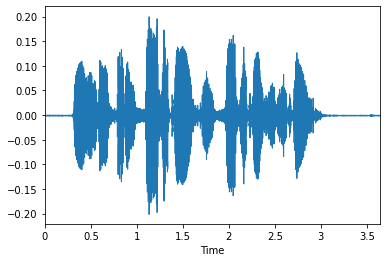

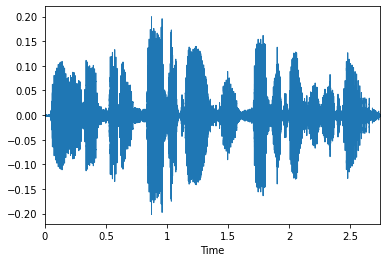

In [ ]:
silencer = RemoveSilence(threshold=20, pad_ms=20)
orig, silenced = show_transform(silencer, GenExample.audio_sc)
# test that at least a half second of silence is being removed
test(silenced.nsamples + 8000, orig.nsamples, operator.le)

In [ ]:
#test that nothing is removed from audio that doesnt contain silence
audio_orig = GenExample.audio_sc()
test_aud = AudioTensor(torch.rand_like(audio_orig), 16000)
orig_samples = test_aud.nsamples
print(f"Random Noise, no silence, {orig_samples} samples")

for rm_type in [RemoveType.All, RemoveType.Trim, RemoveType.Split]:
    silence_audio_trim = RemoveSilence(rm_type, threshold=20, pad_ms=20)(test_aud)
    print(f"After silence remove {rm_type}, {silence_audio_trim.nsamples} samples")
    test_eq(orig_samples, silence_audio_trim.nsamples)

Random Noise, no silence, 58240 samples
After silence remove all, 58240 samples
After silence remove trim, 58240 samples
After silence remove split, 58240 samples


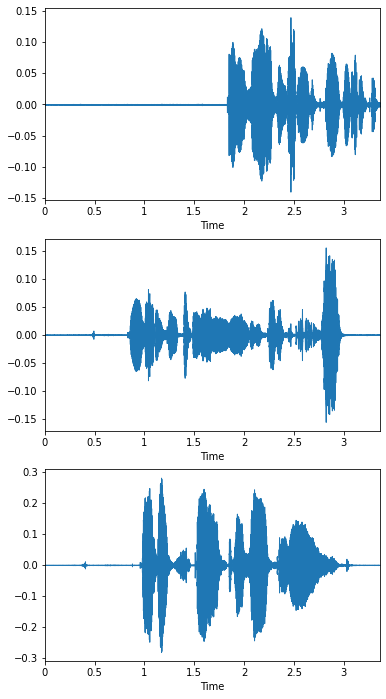

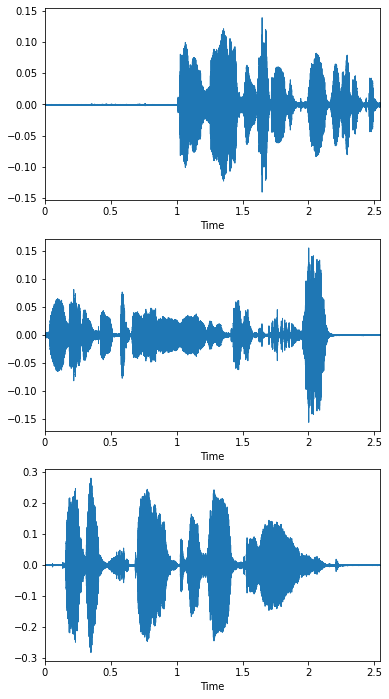

In [ ]:
# trim silence from a multichannel clip, needs more extensive testing
silence_mc = RemoveSilence(threshold=20, pad_ms=20)
inp, out = show_transform(silence_mc, GenExample.audio_mc)

#### Trim Silence Timing Tests

In [ ]:
silencer = RemoveSilence(threshold=20, pad_ms=20)
audio_sc = GenExample.audio_sc()
audio_mc = GenExample.audio_mc()

In [ ]:
%%timeit -n10
silencer(audio_sc)

714 µs ± 222 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit -n10
silencer(audio_mc)

1.41 ms ± 161 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Resampling

In [ ]:
#export
class Resample(Transform):
    '''Resample using faster polyphase technique and avoiding FFT computation'''
    def __init__(self, sr_new):
        self.sr_new = sr_new
        
    def encodes(self, ai:AudioTensor)->AudioTensor:
        if(ai.sr == self.sr_new): return ai
        sig_np = ai.numpy()
        sr_gcd = math.gcd(ai.sr, self.sr_new)
        resampled = resample_poly(sig_np, int(self.sr_new/sr_gcd), int(ai.sr/sr_gcd), axis=-1)
        ai.data = torch.from_numpy(resampled.astype(np.float32))
        ai.sr = self.sr_new
        return ai

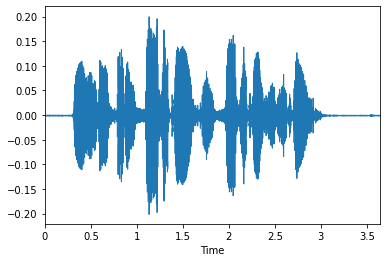

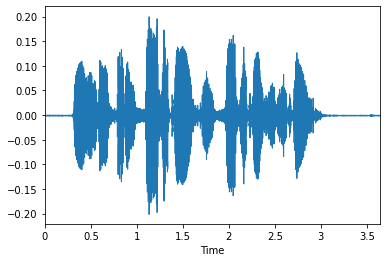

In [ ]:
#Make sure if old and new sample rates are the same, a new identical AudioTensor is returned
no_resample_needed = Resample(audio_orig.sr)
inp, out = show_transform(no_resample_needed, GenExample.audio_sc, hear=True)
test_eq(inp.sr, out.sr)
test_eq(inp, out)

In [ ]:
#test and hear realistic sample rates
audio_orig = GenExample.audio_sc()
orig_sr = audio_orig.sr
print(f"Original Sample Rate {orig_sr} \n")
for rate in [2000,4000,8000,22050,44100]:
    resampler = Resample(rate)
    print("Sample Rate", rate)
    inp, out = show_transform(resampler, GenExample.audio_sc, show=False, hear=True)
    test_eq(out.nsamples, inp.nsamples//(orig_sr/rate))

Original Sample Rate 16000 

Sample Rate 2000


Sample Rate 4000


Sample Rate 8000


Sample Rate 22050


Sample Rate 44100


In [ ]:
#resample a multichannel audio
resampler = Resample(8000)
inp, out = show_transform(resampler, GenExample.audio_mc, show=False, hear=True)
test_eq(inp.nsamples//2, out.nsamples)
test_eq(inp.nchannels, out.nchannels)
test_eq(out.sr, 8000)

In [ ]:
for i in range(100):
    audio_orig = GenExample.audio_sc()
    random_sr = random.randint(16000, 72000)
    random_upsample = Resample(random_sr)(audio_orig)
    num_samples = random_upsample.nsamples
    test_close(num_samples, abs(audio_orig.nsamples//(audio_orig.sr/random_sr)), eps=1.1)

#### Resample Timing Tests

In [ ]:
# Polyphase resampling's speed is dependent on the GCD between old and new rate. For almost all used sample rates it
# will be very fast and much better than any FFT based method. It is slow however in the unlikely event that the 
# GCD is small (demonstrated below w GCD of 1 for last 2 examples)
common_downsample = Resample(8000)
slow_downsample = Resample(8001)
slow_upsample = Resample(27101)
audio_sc = GenExample.audio_sc()
audio_mc = GenExample.audio_mc()

In [ ]:
%%time
common_downsample(audio_sc)

CPU times: user 1.44 ms, sys: 98 µs, total: 1.53 ms
Wall time: 1.29 ms


AudioTensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -2.7515e-04,
         -2.1502e-04, -3.7679e-05]])

In [ ]:
%%time
common_downsample(audio_mc)

CPU times: user 2.95 ms, sys: 0 ns, total: 2.95 ms
Wall time: 2.76 ms


AudioTensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.7625e-03,
         -1.2562e-03, -6.0365e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -3.1290e-05,
         -3.8538e-05,  1.0710e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  4.9272e-05,
          3.9761e-05,  8.9849e-05]])

In [ ]:
%%time
slow_downsample(audio_sc)

CPU times: user 16.2 ms, sys: 0 ns, total: 16.2 ms
Wall time: 16 ms


AudioTensor([[ 1.3499e-23,  2.6595e-12, -1.2066e-11,  ..., -2.6653e-04,
         -1.5343e-04, -3.0850e-06]])

In [ ]:
%%time
slow_upsample(audio_mc)

CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 59.7 ms


AudioTensor([[ 2.7587e-24,  1.1815e-09,  1.7938e-09,  ..., -3.7292e-04,
         -1.7601e-04, -3.4302e-05],
        [-9.0046e-25,  2.0666e-09,  3.0623e-09,  ...,  9.8098e-05,
          6.0099e-05,  1.4080e-05],
        [ 1.8593e-24,  3.2510e-09,  4.8764e-09,  ...,  6.8579e-05,
          3.7435e-05,  8.0894e-06]])

## Export

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()